# Basic Analysis

## Tweet and user volume

In [7]:
import pandas as pd
import numpy as np
import warnings
import re
import itertools
import collections
from datetime import datetime
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv ('data/tweets/IchBinHanna.csv')
#df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag','user.group']]

In [3]:
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_date = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [4]:
#number of total tweets
print(df.shape[0])
#number of total unique users
print(len(pd.unique(df['author.username'])))

116928
19032


In [5]:
#List the distribution of languages in the tweets (important for preprocessing (stopwords etc.))
print(df_date['lang'].value_counts())

de     99219
en     13648
und     3147
fr       302
ja        61
es        52
nl        51
it        32
is        29
da        21
pt        20
no        18
lt        17
tr        16
ca        14
pl        14
sv        14
ro         6
hi         4
et         4
cs         3
in         3
ar         3
tl         3
fi         3
lv         3
fa         2
cy         2
ht         2
vi         1
zh         1
ru         1
eu         1
Name: lang, dtype: int64


As tweets with undefined language mostly consist of only hashtags, URls or emojis, they will be discarded. Otherwise only german and english tweets are kept for the analysis

In [6]:
#This was relevant in an older version of the dataset, before user profiles were added; now the data set contains only german and english tweets to begin with
df_date = df_date.loc[(df_date['lang'] == "de") | (df_date['lang'] == "en")]

In [7]:
pd.set_option('display.max_rows', 100)
#number of remaining tweets
print(df_date.shape[0])
#number of remaining unique users
print(len(pd.unique(df_date['author.id'])))
#overview over "missing values"
print(df_date.count())

112867
18534
__twarc.retrieved_at                                95949
__twarc.url                                         95949
__twarc.version                                     95949
attachments.media                                    2774
attachments.media_keys                               2774
attachments.poll.duration_minutes                      83
attachments.poll.end_datetime                          83
attachments.poll.id                                    83
attachments.poll.options                               83
attachments.poll.voting_status                         83
attachments.poll_ids                                   88
author.created_at                                  112867
author.description                                 107368
author.entities.description.cashtags                    9
author.entities.description.hashtags                39280
author.entities.description.mentions                49795
author.entities.description.urls                     7509
a

<AxesSubplot:xlabel='week'>

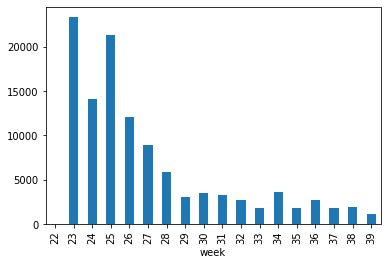

In [8]:
week_groups = df_date.groupby([pd.to_datetime(df_date['new_date']).dt.isocalendar().week]).size()
week_groups.plot(kind='bar', legend = False)

In [9]:
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]

<AxesSubplot:xlabel='new_date'>

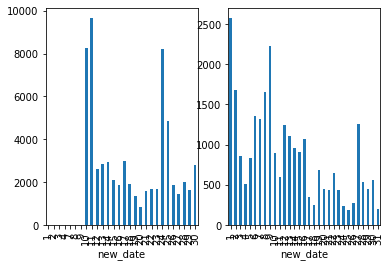

In [10]:
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
june_groups.plot(kind='bar', legend = False)
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
july_groups.plot(kind='bar', legend = False)

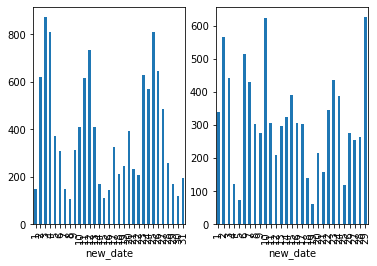

In [11]:
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
august_groups.plot(kind='bar', legend = False)
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
september_groups.plot(kind='bar', legend = False)
plt.xticks(rotation ='vertical')
plt.show()

## Missing Hashtag-Problem

In [12]:
#number of tweets actually containing the hashtag
df_hash = df_date[df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_hash.shape[0])

60832


In [13]:
#number of tweets not containing the hashtag directly
df_no_hash = df_date[-df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_no_hash.shape[0])

52035


In [14]:
#number of tweets without the hashtag that are retweets (text from original tweet cut off)
print(df_no_hash[df_no_hash['reference_type'] == 'retweeted'].shape[0])
#number of tweets with the hashtag that are retweets
print(df_hash[df_hash['reference_type'] == 'retweeted'].shape[0])

47468
40896


In [15]:
test =df_no_hash['text'].loc[df_no_hash['reference_type'] != 'retweeted']
test

2         Hanna is probably packing her/his/they suitcas...
80        Gefühlt die ganze Sozialwissenschaftsnation be...
84        Sobering data from @AAUP: In the fall of 2019,...
90        I finally heard from JW. *Some* of the misogyn...
108       QS World University Rankings 2022: Top 10: 5 🇺...
                                ...                        
116896    "Kaputte Böden, alte zerkratzte Tische und ein...
116905    "Museumsverband Sachsen-Anhalt" https://t.co/V...
116907    A few years back at a conference, a prof told ...
116912    Überwiegend befristete Verträge sorgen für Pre...
116926    Verhandelter Tarif.\nRechtsschutz im Arbeitsle...
Name: text, Length: 4567, dtype: object

In [16]:
print(df_hash['reference_type'].value_counts())
print(df_no_hash['reference_type'].value_counts())

retweeted       40896
no_reference     8159
quoted           6205
replied_to       5572
Name: reference_type, dtype: int64
retweeted       47468
replied_to       2760
no_reference     1253
quoted            554
Name: reference_type, dtype: int64


As a majority of those tweets are retweets that are mostly cut off due to the character constraint, a first approach is to exclude retweets directly for the sentiment analysis, as the original tweet (as long as it falls into our time frame) is most likely in the collection as well. If certain users or networks have to be observed, the whole data set might be of more interest.

In [17]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df_no_hash.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Get top hashtags appearing in tweets along with #IchBinHanna

In [18]:
#make the hashtags a list of strings, then adapt the monthly data frames, also remove tweets not containing the hashtag,
#but keep retweets for this part of the analysis
df_date = df_hash
df_date['hashtags'] = df_hash['hashtags'].str.replace('[', '').str.replace(']','')
df_date['hashtags separated'] = df_date['hashtags'].str.split(',')
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()

In [19]:
print(len(df_september))
print(len(df_june))
print(len(df_july))
print(len(df_august))

4455
37258
13642
5477


In [20]:
#flatten the lists to count occurences of all strings and drop all variations of #IchBinHanna
flat_hashtags = df_september['hashtags separated'].explode().to_frame().dropna()
flat_hashtags = flat_hashtags[-flat_hashtags['hashtags separated'].str.contains("ichbinhanna", case = False)]

In [21]:
#count occurences 
hashtag_count = flat_hashtags.value_counts()
hashtag_count = hashtag_count[hashtag_count > 10].reset_index()

In [22]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='top_hashtags.csv')  
hashtag_count.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Identify Events by observing spikes in tweet volume

In [23]:
print("Highest activity in June:\n{}".format(june_groups.sort_values(ascending = False).head(10)))
print("Highest activity in July:\n{}".format(july_groups.sort_values(ascending = False).head(10)))
print("Highest activity in August:\n{}".format(august_groups.sort_values(ascending = False).head(10)))
print("Highest activity in September:\n{}".format(september_groups.sort_values(ascending = False).head(10)))

Highest activity in June:
new_date
11    5989
10    4566
24    4168
25    3019
14    1852
17    1689
30    1514
12    1502
13    1420
26    1271
dtype: int64
Highest activity in July:
new_date
1     1465
9     1258
8     1048
2     1045
6      693
7      682
12     679
16     512
13     486
10     477
dtype: int64
Highest activity in August:
new_date
3     491
25    441
2     390
12    369
4     347
10    280
23    270
26    268
20    204
11    204
dtype: int64
Highest activity in September:
new_date
10    397
29    362
23    285
2     246
6     245
7     231
24    201
1     198
11    190
22    175
dtype: int64


### First approach: search for most frequent words in tweets with the hashtag for the days with the highest activity

Retweets are kept here, as they give an indication about the engagement of a topic and reflect that in a higher word count for frequently discussed themes.

In [24]:
#First step: process the raw text data
#remove linebreaks separately
df_date['processed text'] = df_date['text'].replace(r'\\n',  ' ', regex=True)
#function to remove URLs, punctuation, @ etc. (source: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/)
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
df_date['processed text'] = df_date['processed text'].apply(rem_url)

In [25]:
#lowercases and tokenize text
df_date['processed text'] = df_date['processed text'].str.lower().str.split()

In [26]:
#remove german and english stopwords (separately for the given language of a tweet)
nltk.download("stopwords")
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
df_date['processed w/o stopwords'] = df_date[['processed text','lang']].apply(lambda x: ' '.join([word for word in x['processed text'] if word not in (english_stop)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed text'] if word not in (german_stop)]).split(),axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
#remove all words consisting of only one character (isn'"t", it'"s" etc.)
df_date['processed w/o stopwords'] = df_date['processed w/o stopwords'].apply(lambda x: [word for word in x if len(word) > 2])

In [28]:
#most frequent words overall
all_words = list(itertools.chain(*df_date['processed w/o stopwords']))
total_word_count = collections.Counter(all_words)
total_word_count.most_common(25)

[('ichbinhanna', 59236),
 ('innen', 6229),
 ('amreibahr', 5585),
 ('bund', 5301),
 ('bmbf', 5075),
 ('amp', 5056),
 ('wissenschaft', 4578),
 ('wisszeitvg', 4384),
 ('hanna', 4134),
 ('wissenschaftler', 3673),
 ('drkeichhorn', 3410),
 ('viele', 3240),
 ('mehr', 2953),
 ('german', 2848),
 ('mal', 2501),
 ('heute', 2452),
 ('system', 2256),
 ('ichbinhannah', 2251),
 ('geht', 2099),
 ('schon', 1968),
 ('anjakarliczek', 1871),
 ('gibt', 1840),
 ('gerade', 1794),
 ('hannaimbundestag', 1754),
 ('gew', 1715)]

In [29]:
#remove additional stopwords encountered (like "innen" which occurs because of gendering in german), as well as the hashtag itself, rt etc.
add_stop_all = ["rt", "ichbinhanna", "hanna", "amp"]
add_stop_ger = ["mehr", "mal", "innen", "ja", "schon"]
add_stop_en = []
df_date['processed w/o stopwords'] = df_date[['processed w/o stopwords','lang']].apply(lambda x: ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_en)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_ger)]).split(),axis=1)

In [30]:
#get most frequent terms for days with highest tweet volume per month
current_day = df_date.loc[(df_date['new_date'] > '2021-06-10 00:00:00') & (df_date['new_date'] <= '2021-06-10 23:59:59')]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-11 00:00:00') & (df_date['new_date'] <= '2021-06-11 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("11.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-24 00:00:00') & (df_date['new_date'] <= '2021-06-24 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("24.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-25 00:00:00') & (df_date['new_date'] <= '2021-06-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-17 00:00:00') & (df_date['new_date'] <= '2021-06-17 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("17.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-30 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("30.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-01 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("01.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-02 00:00:00') & (df_date['new_date'] <= '2021-07-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-09 00:00:00') & (df_date['new_date'] <= '2021-07-09 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("09.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-08 00:00:00') & (df_date['new_date'] <= '2021-07-08 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("08.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-03 00:00:00') & (df_date['new_date'] <= '2021-08-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-04 00:00:00') & (df_date['new_date'] <= '2021-08-04 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("04.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-25 00:00:00') & (df_date['new_date'] <= '2021-08-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-12 00:00:00') & (df_date['new_date'] <= '2021-08-12 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("12.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-26 00:00:00') & (df_date['new_date'] <= '2021-08-26 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("26.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-29 00:00:00') & (df_date['new_date'] <= '2021-09-29 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("29.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-10 00:00:00') & (df_date['new_date'] <= '2021-09-10 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-02 00:00:00') & (df_date['new_date'] <= '2021-09-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-06 00:00:00') & (df_date['new_date'] <= '2021-09-06 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("06.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-03 00:00:00') & (df_date['new_date'] <= '2021-09-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.09.:\n{}".format(daily_word_count.most_common(25)))

10.06.:
[('wissenschaftler', 939), ('teilen', 786), ('wisszeitvg', 631), ('befristet', 593), ('prekären', 591), ('nachwuchs', 568), ('momentan', 530), ('status', 530), ('angestellte', 529), ('degneranja', 528), ('wissenschaft', 522), ('bmbf', 484), ('german', 341), ('viele', 324), ('innovation', 309), ('gerade', 278), ('deutschland', 267), ('sagt', 254), ('tatsächlich', 254), ('kontext', 250), ('sorgt', 248), ('schwere', 247), ('fördere', 246), ('trending', 245), ('sahiralsaid', 244)]
11.06.:
[('wissenschaftler', 799), ('german', 748), ('wissenschaft', 660), ('system', 613), ('viele', 601), ('teilen', 592), ('trending', 588), ('academic', 557), ('gerade', 438), ('bmbf', 373), ('academia', 335), ('since', 333), ('know', 327), ('befristungen', 317), ('martin', 313), ('wisszeitvg', 308), ('everyone', 308), ('messed', 305), ('hebart', 304), ('pia', 304), ('lamberty', 303), ('bec', 302), ('befristet', 295), ('tweets', 293), ('übrigens', 292)]
24.06.:
[('hannaimbundestag', 1104), ('geht', 41

### Observations June:
10th + 11th: Start of the movement under the hashtag #IchBinHanna
24th: Issue got discussed in the "aktuelle Stunde" of the german Bundestag
25th: Series of tweets of Achim Landwehr, a Dean of studies critizing and portraying the situation of scientific workers
17th: State scecretary Wolf-Dieter Lukas uploads a video addressing the issues that arose with the hashtag
14th: Initial video of the BMBF gets deleted from their website.

### Observations July:
1st +  2nd: Zoom conference of the GEW (union for education and science) 
9th: Journalist Thilo Jung presents the issue at a press conference of the german government 

### Observations August:
3rd + 4th: TV report about #IchBinHanna in ZDF's "heute journal" 

### Observations September:
2nd + 3rd: declaration of new "Berliner Hochschulgesetz"
29th: IchBinHanna discussed in the "hessischer Landtag"

## Distribution of user profiles

In [50]:
df_no_bots = df_date.loc[(df_date['user.group']!='Bot')& (df_date['user.group']!='Academic unspecified')]
df_june_no_bots = df_june.loc[(df_june['user.group']!='Bot')& (df_june['user.group']!='Academic unspecified')]
df_july_no_bots = df_july.loc[(df_july['user.group']!='Bot')& (df_july['user.group']!='Academic unspecified')]
df_august_no_bots = df_august.loc[(df_august['user.group']!='Bot')& (df_august['user.group']!='Academic unspecified')]
df_september_no_bots = df_september.loc[(df_september['user.group']!='Bot')& (df_september['user.group']!='Academic unspecified')]
df_date['user.group'].value_counts()/40956

Postdoc                 0.447285
Academic unspecified    0.248608
Promovierende           0.091586
Prof                    0.076155
Bot                     0.034989
Media                   0.027615
Student                 0.022951
Institution             0.016823
Union rep               0.013576
Political rep           0.008985
Jun. prof               0.007813
Teacher                 0.003492
Medical doctor          0.000122
Name: user.group, dtype: float64

In [47]:
unique_users = df_date.drop_duplicates('author.username')
unique_users['user.group'].value_counts()/5625

Academic unspecified    0.361422
Postdoc                 0.213867
Promovierende           0.143822
Prof                    0.112889
Media                   0.052267
Student                 0.050133
Political rep           0.019911
Teacher                 0.014578
Institution             0.010667
Union rep               0.009244
Jun. prof               0.006044
Bot                     0.004622
Medical doctor          0.000533
Name: user.group, dtype: float64

array(['diballestero', 'schuh_melissa', 'TimTheRose', ...,
       'HetEconVienna', 'heinekenuwe', 'ProfCha0s84'], dtype=object)

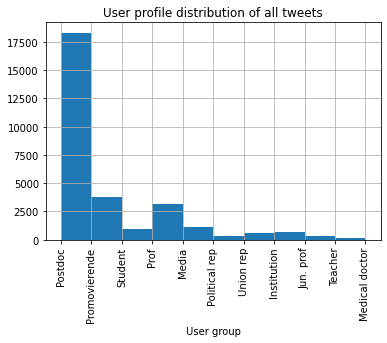

In [33]:
#whole data set
df_no_bots['user.group'].hist()
plt.title('User profile distribution of all tweets')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

To get a broader picture and see if the participants of the discussion changed over time, the distribution is also shown for the single months

In [51]:
df_june['user.group'].value_counts()/len(df_june)

Postdoc                 0.266762
Academic unspecified    0.159053
Promovierende           0.061544
Prof                    0.053707
Media                   0.019539
Bot                     0.018707
Student                 0.017070
Institution             0.008965
Political rep           0.007086
Union rep               0.006656
Jun. prof               0.005932
Teacher                 0.002818
Medical doctor          0.000134
Name: user.group, dtype: float64

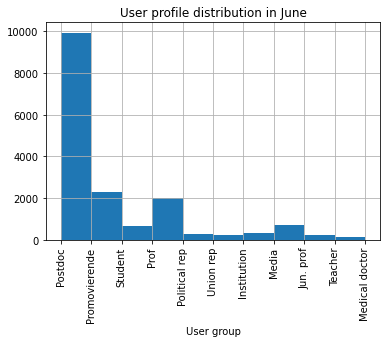

In [35]:
#distribution in June
df_june_no_bots['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

In [52]:
df_july['user.group'].value_counts()/len(df_july)

Postdoc                 0.332283
Academic unspecified    0.190441
Promovierende           0.063187
Prof                    0.055857
Bot                     0.034233
Media                   0.017593
Institution             0.015027
Student                 0.013854
Union rep               0.009090
Jun. prof               0.004325
Political rep           0.004178
Teacher                 0.002199
Name: user.group, dtype: float64

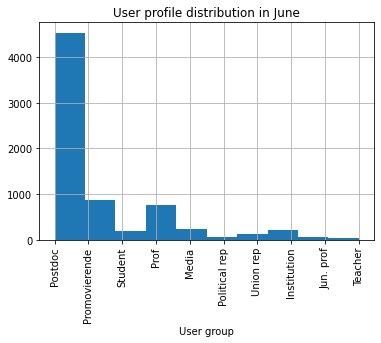

In [37]:
#distribution in July
df_july_no_bots['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

In [53]:
df_august['user.group'].value_counts()/len(df_august)

Postdoc                 0.383422
Academic unspecified    0.165236
Promovierende           0.062078
Prof                    0.041081
Bot                     0.036516
Media                   0.016432
Union rep               0.013511
Student                 0.011868
Institution             0.010407
Political rep           0.005112
Jun. prof               0.004930
Teacher                 0.001278
Name: user.group, dtype: float64

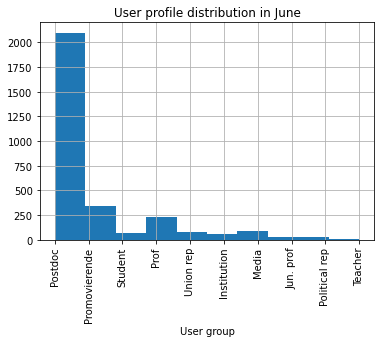

In [39]:
#distribution in August
df_august_no_bots['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

In [54]:
df_september['user.group'].value_counts()/len(df_september)

Postdoc                 0.392144
Academic unspecified    0.169024
Promovierende           0.057464
Prof                    0.029405
Union rep               0.024691
Institution             0.020875
Media                   0.016386
Bot                     0.015488
Student                 0.011223
Political rep           0.004265
Jun. prof               0.002918
Teacher                 0.000224
Name: user.group, dtype: float64

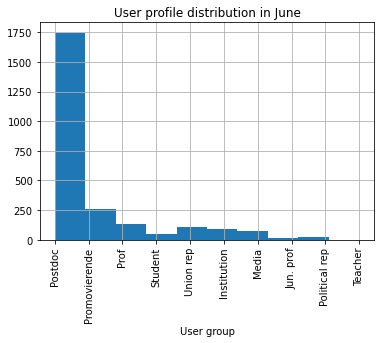

In [41]:
#distribution in August
df_september_no_bots['user.group'].hist()
plt.title('User profile distribution in June')
plt.xlabel('User group')
plt.xticks(rotation='vertical')
plt.show()

## Updated Data Set

The data set was updated to include tweets until April 2022 and the same analysis is performed on the newly obtained tweets to detect further events

In [8]:
df_new = pd.read_csv ('data/tweets/IchBinHanna_updated.csv')

In [9]:
#only keep tweets from 01/06/2021 - 30/09/2021
df_new['date'] = pd.to_datetime(df_new['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_new_date = df_new.loc[(df_new['date'] > '2021-10-01 00:00:00') & (df_new['date'] <= '2022-04-14 23:59:59')]

In [10]:
#number of total tweets
print(df_new_date.shape[0])
#number of total unique users
print(len(pd.unique(df_new_date['author.username'])))

21291
4963


In [11]:
print(len(pd.unique(df_new_date['id'])))
df_new_date = df_new_date.drop_duplicates(subset = ['id'])

21247


In [12]:
#number of total tweets
print(df_new_date.shape[0])
#number of total unique users
print(len(pd.unique(df_new_date['author.username'])))

21247
4963


In [13]:
print(df_new_date['lang'].value_counts())

de     18250
en      1742
und     1148
fr        25
es        17
no        12
in        10
ht         8
lt         7
da         5
tr         5
it         3
cs         3
ko         2
is         2
pt         2
nl         2
fi         1
ro         1
et         1
cy         1
Name: lang, dtype: int64


In [14]:
df_new_date = df_new_date.loc[(df_new_date['lang'] == "de") | (df_new_date['lang'] == "en")]

In [15]:
#number of remaining tweets
print(df_new_date.shape[0])
#number of remaining unique users
print(len(pd.unique(df_new_date['author.id'])))
#overview over "missing values"
print(df_new_date.count())

19992
4708
author.created_at                        19992
author.description                       19253
author.id                                19992
author.location                          12754
author.name                              19992
author.public_metrics.followers_count    19992
author.public_metrics.following_count    19992
author.public_metrics.listed_count       19992
author.public_metrics.tweet_count        19992
author.username                          19992
conversation_id                          19992
created_at                               19992
id                                       19992
lang                                     19992
public_metrics.like_count                19992
public_metrics.quote_count               19992
public_metrics.reply_count               19992
public_metrics.retweet_count             19992
text                                     19992
reference_type                           19992
date                                     19992
dt

<AxesSubplot:xlabel='week'>

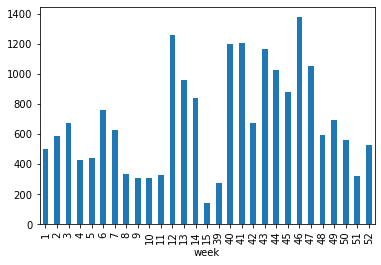

In [16]:
week_groups = df_new_date.groupby([pd.to_datetime(df_new_date['date']).dt.isocalendar().week]).size()
week_groups.plot(kind='bar', legend = False)

In [17]:
df_new_oct = df_new_date.loc[(df_new_date['date'] > '2021-10-01 00:00:00') & (df_new_date['date'] <= '2021-10-31 23:59:59')]
df_new_nov = df_new_date.loc[(df_new_date['date'] > '2021-11-01 00:00:00') & (df_new_date['date'] <= '2021-11-30 23:59:59')]
df_new_dec = df_new_date.loc[(df_new_date['date'] > '2021-12-01 00:00:00') & (df_new_date['date'] <= '2021-12-31 23:59:59')]
df_new_jan = df_new_date.loc[(df_new_date['date'] > '2022-01-01 00:00:00') & (df_new_date['date'] <= '2022-01-31 23:59:59')]
df_new_feb = df_new_date.loc[(df_new_date['date'] > '2022-02-01 00:00:00') & (df_new_date['date'] <= '2022-02-28 23:59:59')]
df_new_mar = df_new_date.loc[(df_new_date['date'] > '2022-03-01 00:00:00') & (df_new_date['date'] <= '2022-03-31 23:59:59')]
df_new_apr = df_new_date.loc[(df_new_date['date'] > '2022-04-01 00:00:00') & (df_new_date['date'] <= '2022-04-14 23:59:59')]
oct_groups = df_new_oct.groupby([pd.to_datetime(df_new_oct['date']).dt.day]).size()
nov_groups = df_new_nov.groupby([pd.to_datetime(df_new_nov['date']).dt.day]).size()
dec_groups = df_new_dec.groupby([pd.to_datetime(df_new_dec['date']).dt.day]).size()
jan_groups = df_new_jan.groupby([pd.to_datetime(df_new_jan['date']).dt.day]).size()
feb_groups = df_new_feb.groupby([pd.to_datetime(df_new_feb['date']).dt.day]).size()
mar_groups = df_new_mar.groupby([pd.to_datetime(df_new_mar['date']).dt.day]).size()
apr_groups = df_new_apr.groupby([pd.to_datetime(df_new_apr['date']).dt.day]).size()

<AxesSubplot:xlabel='date'>

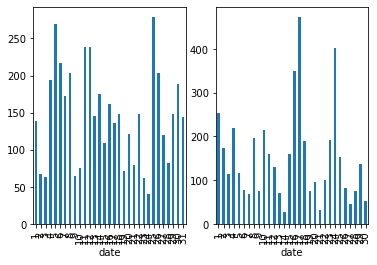

In [18]:
plt.subplot(1, 2, 1)
oct_groups.plot(kind='bar', legend = False)
plt.subplot(1, 2, 2)
nov_groups.plot(kind='bar', legend = False)

<AxesSubplot:xlabel='date'>

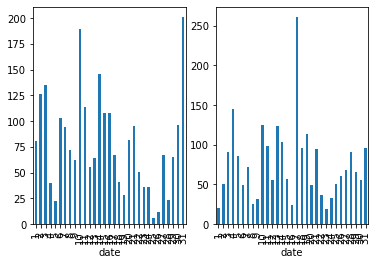

In [19]:
plt.subplot(1, 2, 1)
dec_groups.plot(kind='bar', legend = False)
plt.subplot(1, 2, 2)
jan_groups.plot(kind='bar', legend = False)

<AxesSubplot:xlabel='date'>

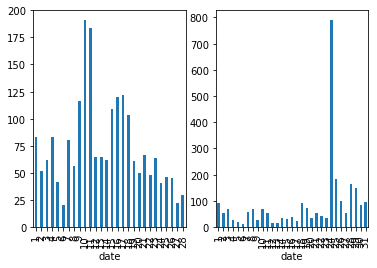

In [20]:
plt.subplot(1, 2, 1)
feb_groups.plot(kind='bar', legend = False)
plt.subplot(1, 2, 2)
mar_groups.plot(kind='bar', legend = False)

<AxesSubplot:xlabel='date'>

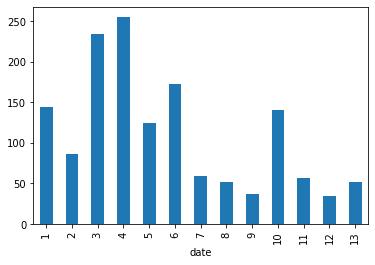

In [21]:
apr_groups.plot(kind='bar', legend = False)

In [23]:
#First step: process the raw text data
#remove linebreaks separately
df_new_date['processed text'] = df_new_date['text'].replace(r'\\n',  ' ', regex=True)
#function to remove URLs, punctuation, @ etc. (source: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/)
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
df_new_date['processed text'] = df_new_date['processed text'].apply(rem_url)

In [24]:
#lowercases and tokenize text
df_new_date['processed text'] = df_new_date['processed text'].str.lower().str.split()

In [26]:
#remove german and english stopwords (separately for the given language of a tweet)
nltk.download("stopwords")
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
df_new_date['processed w/o stopwords'] = df_new_date[['processed text','lang']].apply(lambda x: ' '.join([word for word in x['processed text'] if word not in (english_stop)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed text'] if word not in (german_stop)]).split(),axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
#remove all words consisting of only one character (isn'"t", it'"s" etc.)
df_new_date['processed w/o stopwords'] = df_new_date['processed w/o stopwords'].apply(lambda x: [word for word in x if len(word) > 2])

In [30]:
#remove additional stopwords encountered (like "innen" which occurs because of gendering in german), as well as the hashtag itself, rt etc.
add_stop_all = ["rt", "ichbinhanna", "hanna", "amp"]
add_stop_ger = ["mehr", "mal", "innen", "ja", "schon"]
add_stop_en = []
df_new_date['processed w/o stopwords'] = df_new_date[['processed w/o stopwords','lang']].apply(lambda x: ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_en)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_ger)]).split(),axis=1)

In [31]:
#most frequent words overall
all_words = list(itertools.chain(*df_new_date['processed w/o stopwords']))
total_word_count = collections.Counter(all_words)
total_word_count.most_common(25)

[('amreibahr', 4134),
 ('ichbinreyhan', 2196),
 ('wissenschaft', 1592),
 ('gut', 1200),
 ('buch', 1178),
 ('suhrkamp', 1108),
 ('initiative', 1072),
 ('heute', 1035),
 ('drkeichhorn', 1029),
 ('tweet', 1013),
 ('kaum', 970),
 ('monate', 967),
 ('halten', 928),
 ('bund', 904),
 ('glauben', 875),
 ('händen', 872),
 ('gew', 855),
 ('sebastiankubon', 754),
 ('geht', 749),
 ('uni', 680),
 ('wisssystemfehler', 665),
 ('gibt', 652),
 ('ichbinhannah', 607),
 ('jenniferhenkehb', 597),
 ('arbeitsbedingungen', 588)]

In [36]:
#get most frequent terms for days with highest tweet volume per month
def words_per_day(df,start,end,date):    
    current_day = df.loc[(df['date'] > start ) & (df['date'] <= end)]
    daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
    daily_word_count = collections.Counter(daily_words)
    print("{0}:\n{1}".format(date,daily_word_count.most_common(25)))

In [41]:
words_per_day(df_new_date,'2021-10-25 00:00:00', '2021-10-25 23:59:59', '25.10.')
words_per_day(df_new_date,'2021-10-05 00:00:00', '2021-10-05 23:59:59', '05.10.')
words_per_day(df_new_date,'2021-10-11 00:00:00', '2021-10-11 23:59:59', '11.10.')
words_per_day(df_new_date,'2021-10-12 00:00:00', '2021-10-12 23:59:59', '12.10.')
words_per_day(df_new_date,'2021-10-06 00:00:00', '2021-10-06 23:59:59', '06.10.')
words_per_day(df_new_date,'2021-11-17 00:00:00', '2021-11-17 23:59:59', '17.11.')
words_per_day(df_new_date,'2021-11-24 00:00:00', '2021-11-24 23:59:59', '24.11.')
words_per_day(df_new_date,'2021-11-16 00:00:00', '2021-11-16 23:59:59', '16.11.')
words_per_day(df_new_date,'2021-11-01 00:00:00', '2021-11-01 23:59:59', '01.11.')
words_per_day(df_new_date,'2021-11-04 00:00:00', '2021-11-04 23:59:59', '04.11.')
words_per_day(df_new_date,'2021-12-31 00:00:00', '2021-12-31 23:59:59', '31.12.')
words_per_day(df_new_date,'2021-12-10 00:00:00', '2021-12-10 23:59:59', '10.12.')
words_per_day(df_new_date,'2021-12-14 00:00:00', '2021-12-14 23:59:59', '14.12.')
words_per_day(df_new_date,'2021-12-03 00:00:00', '2021-12-03 23:59:59', '03.12.')
words_per_day(df_new_date,'2021-12-02 00:00:00', '2021-12-02 23:59:59', '02.12.')
words_per_day(df_new_date,'2022-01-17 00:00:00', '2022-01-17 23:59:59', '17.01.')
words_per_day(df_new_date,'2022-01-04 00:00:00', '2022-01-04 23:59:59', '04.01.')
words_per_day(df_new_date,'2022-01-10 00:00:00', '2022-01-10 23:59:59', '10.01.')
words_per_day(df_new_date,'2022-01-13 00:00:00', '2022-01-13 23:59:59', '13.01.')
words_per_day(df_new_date,'2022-01-19 00:00:00', '2022-01-19 23:59:59', '19.01.')
words_per_day(df_new_date,'2022-02-10 00:00:00', '2022-02-10 23:59:59', '10.02.')
words_per_day(df_new_date,'2022-02-11 00:00:00', '2022-02-11 23:59:59', '11.02.')
words_per_day(df_new_date,'2022-02-17 00:00:00', '2022-02-17 23:59:59', '17.02.')
words_per_day(df_new_date,'2022-02-16 00:00:00', '2022-02-16 23:59:59', '16.02.')
words_per_day(df_new_date,'2022-02-09 00:00:00', '2022-02-09 23:59:59', '09.02.')
words_per_day(df_new_date,'2022-03-24 00:00:00', '2022-03-24 23:59:59', '24.03.')
words_per_day(df_new_date,'2022-03-25 00:00:00', '2022-03-25 23:59:59', '25.03.')
words_per_day(df_new_date,'2022-03-28 00:00:00', '2022-03-28 23:59:59', '28.03.')
words_per_day(df_new_date,'2022-03-29 00:00:00', '2022-03-29 23:59:59', '29.03.')
words_per_day(df_new_date,'2022-03-26 00:00:00', '2022-03-26 23:59:59', '26.03.')
words_per_day(df_new_date,'2022-04-04 00:00:00', '2022-04-04 23:59:59', '04.04.')
words_per_day(df_new_date,'2022-04-03 00:00:00', '2022-04-03 23:59:59', '03.04.')
words_per_day(df_new_date,'2022-04-06 00:00:00', '2022-04-06 23:59:59', '06.04.')
words_per_day(df_new_date,'2022-04-01 00:00:00', '2022-04-01 23:59:59', '01.04.')
words_per_day(df_new_date,'2022-04-10 00:00:00', '2022-04-10 23:59:59', '10.04.')


25.10.:
[('amreibahr', 148), ('anträge', 108), ('mehrfach', 103), ('daran', 103), ('gescheitert', 103), ('großes', 103), ('drittmittelprojekt', 101), ('einzuwerben', 101), ('umfangreiche', 101), ('wisssystemfehler', 45), ('ichbinreyhan', 31), ('drkeichhorn', 25), ('falls', 19), ('situation', 19), ('qualität', 19), ('jemand', 17), ('fragt', 17), ('studiums', 17), ('auswirkt', 17), ('ichbinhannah', 17), ('bund', 16), ('köln', 15), ('gew', 15), ('bahnhofsvorplatz', 14), ('donnerstag', 13)]
05.10.:
[('amreibahr', 32), ('vhdresolution', 31), ('ichbinreyhan', 29), ('gibt', 26), ('frage', 25), ('unterstützen', 23), ('diskussion', 23), ('wissenschaft', 23), ('histag21', 22), ('befristung', 20), ('ichbinhannah', 19), ('brief', 18), ('kampagne', 18), ('dabei', 18), ('stelle', 18), ('giub', 16), ('research', 16), ('öffentlichen', 15), ('professur', 14), ('mitarbeiter', 14), ('wiss', 13), ('hrk', 13), ('aktuell', 13), ('nga', 13), ('bene', 13)]
11.10.:
[('amreibahr', 69), ('hochschulen', 54), ('tv

In [22]:
print("Highest activity in October:\n{}".format(oct_groups.sort_values(ascending = False).head(10)))
print("Highest activity in November:\n{}".format(nov_groups.sort_values(ascending = False).head(10)))
print("Highest activity in December:\n{}".format(dec_groups.sort_values(ascending = False).head(10)))
print("Highest activity in January:\n{}".format(jan_groups.sort_values(ascending = False).head(10)))
print("Highest activity in February:\n{}".format(feb_groups.sort_values(ascending = False).head(10)))
print("Highest activity in March:\n{}".format(mar_groups.sort_values(ascending = False).head(10)))
print("Highest activity in April:\n{}".format(apr_groups.sort_values(ascending = False).head(10)))

Highest activity in October:
date
25    279
5     270
11    239
12    238
6     217
8     204
26    204
4     194
30    189
14    175
dtype: int64
Highest activity in November:
date
17    473
24    402
16    350
1     253
4     220
10    215
8     196
23    191
18    190
2     174
dtype: int64
Highest activity in December:
date
31    201
10    189
14    146
3     135
2     126
11    114
15    108
16    108
6     103
30     96
dtype: int64
Highest activity in January:
date
17    261
4     145
10    125
13    123
19    113
14    104
11     98
31     96
18     96
21     95
dtype: int64
Highest activity in February:
date
10    191
11    184
17    122
16    120
9     116
15    109
18    103
1      83
4      83
7      80
dtype: int64
Highest activity in March:
date
24    790
25    185
28    164
29    149
26     99
31     97
18     92
1      92
30     86
19     74
dtype: int64
Highest activity in April:
date
4     255
3     234
6     172
1     144
10    140
5     125
2      86
7      59
11   